In [1]:
# this notebook is the implentation of VAE in MNIST dataset
from keras.layers import Dense, Lambda, Input
from keras.models import Model, load_model
from keras.losses import binary_crossentropy, mse
from keras.utils import plot_model
from keras import backend
from keras.optimizers import Adam
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# load the mnist dataset and seperate the training and testing data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
img_size = 28
expand_dim = 28 * 28
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, [-1, expand_dim])
x_test = np.reshape(x_test, [-1, expand_dim])

## **Build the VAE Model**


In [4]:
# define the sample function for sampling varibles
# Uses (z_mean, z_log_var) to sample z, the vector encoding a digit. 
def sampling(mean_var):

  z_mean, z_log_var = mean_var
  batch = backend.shape(z_mean)[0]
  dim = backend.int_shape(z_mean)[1]
  epsilon = backend.random_normal(shape=(batch, dim))
  return z_mean + backend.exp(0.5 * z_log_var)* epsilon

Encoder

In [5]:
input_shape = (expand_dim, )
model_complexity = 512
batch_size = 100
latent_dim = 2
epochs = 50

inputs = Input(shape=input_shape)
h = Dense(model_complexity, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [6]:
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

In [7]:
encoder = Model(inputs, [z_mean, z_log_var, z])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            1026        dense[0][0]                      
______________________________________________________________________________________________

Decoder

In [8]:
latent_space_inputs = Input(shape=(latent_dim, ))
x = Dense(model_complexity, activation='relu')(latent_space_inputs)
outputs = Dense(expand_dim, activation='sigmoid')(x)

In [9]:
decoder = Model(latent_space_inputs, outputs)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [10]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model (Functional)           [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
model_1 (Functional)         (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


Loss Constrcution

In [11]:
reconstruction_loss = binary_crossentropy(inputs, outputs) * expand_dim
kl_loss = 1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var)
kl_loss = backend.sum(kl_loss, axis=-1) 
kl_loss = kl_loss * -0.5
vae_loss = backend.mean(reconstruction_loss+kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

## **Training Model**

In [12]:
vae_history = vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
600/600 [==============================] - 11s 18ms/step - loss: 228.4922 - val_loss: 169.7198
Epoch 2/50
600/600 [==============================] - 10s 17ms/step - loss: 168.3510 - val_loss: 165.4966
Epoch 3/50
600/600 [==============================] - 10s 17ms/step - loss: 164.7259 - val_loss: 163.0920
Epoch 4/50
600/600 [==============================] - 10s 17ms/step - loss: 162.0244 - val_loss: 161.0306
Epoch 5/50
600/600 [==============================] - 10s 17ms/step - loss: 160.3190 - val_loss: 159.7576
Epoch 6/50
600/600 [==============================] - 10s 17ms/step - loss: 159.0495 - val_loss: 158.2356
Epoch 7/50
600/600 [==============================] - 10s 17ms/step - loss: 157.3934 - val_loss: 157.1170
Epoch 8/50
600/600 [==============================] - 10s 17ms/step - loss: 156.5712 - val_loss: 156.2438
Epoch 9/50
600/600 [==============================] - 10s 17ms/step - loss: 155.2444 - val_loss: 155.4469
Epoch 10/50
600/600 [=========================

In [13]:
def lossPlot(train, test):
  x_axis = list(range(len(train)))

  plt.plot(x_axis, train, label='train loss')
  plt.plot(x_axis, test, label='test loss')

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True, linestyle='dotted')
  plt.legend()

  plt.show()

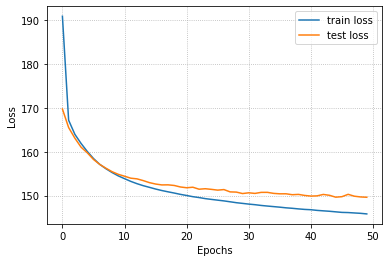

In [14]:
hist = vae_history.history
lossPlot(hist['loss'], hist['val_loss'])

Plot Images

In [15]:
x_test_encoded = vae.predict(x_test, batch_size=batch_size)

In [16]:
def images_gallery(images):
  fig = plt.figure(figsize=(4, 12))
  for index, image in enumerate(images):
    axis_1 = fig.add_subplot(10, 2, index*2+1)
    axis_1.imshow(image[0], cmap=plt.cm.gray)

    axis_2 = fig.add_subplot(10, 2, index*2+2)
    axis_2.imshow(image[1], cmap=plt.cm.gray)

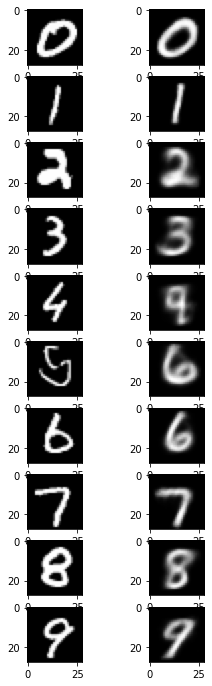

In [17]:
np.random.seed(22)
digits = [0,1,2,3,4,5,6,7,8,9]
images = []

for digit in digits:
  first_index = np.where(y_test==digit)[0]
  ind = first_index[np.random.choice(first_index.shape[0])]

  original_img = x_test[ind].reshape(28, 28)
  encoded = x_test_encoded[ind].reshape(28, 28)

  images.append([original_img, encoded])

images_gallery(images)

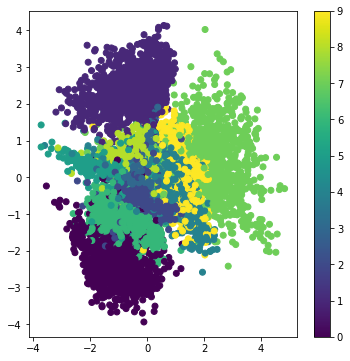

In [18]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded = x_test_encoded[0]

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

## **Tuning Hyperparameters**

In [19]:
def VAE_model(latent_dim=2, model_complexity=512):
  inputs = Input(shape=input_shape)
  h = Dense(model_complexity, activation='relu')(inputs)
  z_mean = Dense(latent_dim)(h)
  z_log_var = Dense(latent_dim)(h)
  z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

  encoder = Model(inputs, [z_mean, z_log_var, z])

  latent_space_inputs = Input(shape=(latent_dim, ))
  x = Dense(model_complexity, activation='relu')(latent_space_inputs)
  outputs = Dense(expand_dim, activation='sigmoid')(x)

  decoder = Model(latent_space_inputs, outputs)

  outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, outputs)

  reconstruction_loss = binary_crossentropy(inputs, outputs) * expand_dim
  kl_loss = 1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var)
  kl_loss = backend.sum(kl_loss, axis=-1) 
  kl_loss = kl_loss * -0.5
  vae_loss = backend.mean(reconstruction_loss+kl_loss)

  vae.add_loss(vae_loss)
  vae.compile(optimizer=Adam())

  return vae

In [20]:
latents = [10, 20]
tuning_latentDims = []
latents_models = []
for latent in latents:
  vae_Model = VAE_model(latent_dim=latent)
  latents_models.append(vae_Model)
  
  vae_hist_tuning = vae_Model.fit(
      x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None)
  )
  tuning_latentDims.append(vae_hist_tuning)

Epoch 1/50
600/600 [==============================] - 11s 18ms/step - loss: 201.1150 - val_loss: 127.2832
Epoch 2/50
600/600 [==============================] - 11s 18ms/step - loss: 126.1091 - val_loss: 119.9179
Epoch 3/50
600/600 [==============================] - 11s 18ms/step - loss: 119.8860 - val_loss: 116.4165
Epoch 4/50
600/600 [==============================] - 11s 18ms/step - loss: 117.0188 - val_loss: 114.5519
Epoch 5/50
600/600 [==============================] - 11s 18ms/step - loss: 114.8926 - val_loss: 113.1517
Epoch 6/50
600/600 [==============================] - 11s 18ms/step - loss: 113.5188 - val_loss: 112.1726
Epoch 7/50
600/600 [==============================] - 10s 17ms/step - loss: 112.6220 - val_loss: 111.2711
Epoch 8/50
600/600 [==============================] - 11s 18ms/step - loss: 111.6199 - val_loss: 110.5261
Epoch 9/50
600/600 [==============================] - 11s 18ms/step - loss: 110.8070 - val_loss: 110.0312
Epoch 10/50
600/600 [=========================

In [21]:
model_complexities = [256, 1024]
comp_models = []
tuningComp = []
for model_com in model_complexities:
  vae_Model = VAE_model(model_complexity=model_com)
  comp_models.append(vae_Model)
  
  vae_hist_tuning = vae_Model.fit(
      x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None)
  )
  tuningComp.append(vae_hist_tuning)


Epoch 1/50
600/600 [==============================] - 8s 12ms/step - loss: 244.1259 - val_loss: 175.1169
Epoch 2/50
600/600 [==============================] - 7s 11ms/step - loss: 173.7854 - val_loss: 168.2652
Epoch 3/50
600/600 [==============================] - 7s 11ms/step - loss: 167.8532 - val_loss: 165.6514
Epoch 4/50
600/600 [==============================] - 7s 11ms/step - loss: 165.0750 - val_loss: 163.8041
Epoch 5/50
600/600 [==============================] - 7s 11ms/step - loss: 163.2273 - val_loss: 162.4447
Epoch 6/50
600/600 [==============================] - 7s 11ms/step - loss: 161.7830 - val_loss: 161.4288
Epoch 7/50
600/600 [==============================] - 7s 11ms/step - loss: 160.8651 - val_loss: 160.4803
Epoch 8/50
600/600 [==============================] - 7s 11ms/step - loss: 159.1855 - val_loss: 159.2891
Epoch 9/50
600/600 [==============================] - 7s 11ms/step - loss: 158.7891 - val_loss: 158.5508
Epoch 10/50
600/600 [==============================] - 

In [34]:
def plot_gallary(x_test_encoded):
  digits = [0,1,2,3,4,5,6,7,8,9]
  images = []

  for digit in digits:
    first_index = np.where(y_test==digit)[0]
    ind = first_index[np.random.choice(first_index.shape[0])]

    original_img = x_test[ind].reshape(28, 28)
    encoded = x_test_encoded[ind].reshape(28, 28)

    images.append([original_img, encoded])

  images_gallery(images)


### ***Results of latent dimensions***

latent dimension: 10


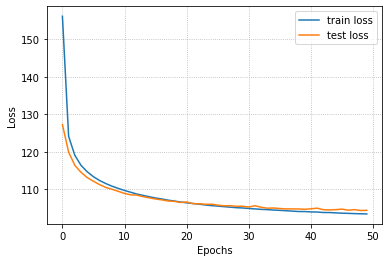

In [29]:
print("latent dimension: "+ str(latents[0]))
latent_10_hist = tuning_latentDims[0]
history_10 = latent_10_hist.history
lossPlot(history_10['loss'], history_10['val_loss'])

latent dimension: 10


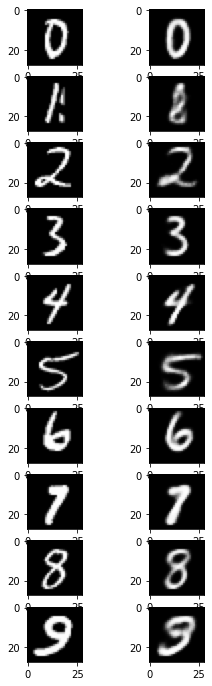

In [38]:
vae_latent_10 = latents_models[0]
x_test_encoded_latent10 = vae_latent_10.predict(x_test, batch_size=batch_size)
print("latent dimension: "+ str(latents[0]))
plot_gallary(x_test_encoded_latent10)

latent dimension: 20


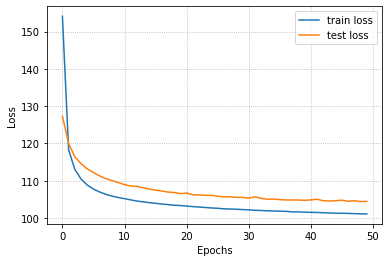

In [30]:
print("latent dimension: "+ str(latents[1]))
latent_20_hist = tuning_latentDims[1]
history_20 = latent_20_hist.history
lossPlot(history_20['loss'], history_10['val_loss'])

latent dimension: 20


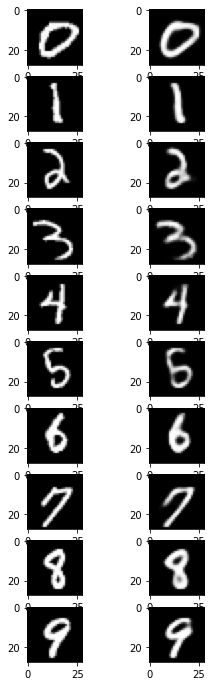

In [39]:
vae_latent_20 = latents_models[1]
x_test_encoded_latent20 = vae_latent_20.predict(x_test, batch_size=batch_size)
print("latent dimension: "+ str(latents[1]))
plot_gallary(x_test_encoded_latent20)

### ***Results of model complexity***

model complexity: 256


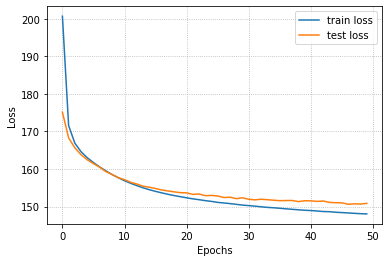

In [42]:
print("model complexity: "+ str(model_complexities[0]))
com256_hist = tuningComp[0].history
lossPlot(com256_hist['loss'],com256_hist['val_loss'])

model complexity: 256


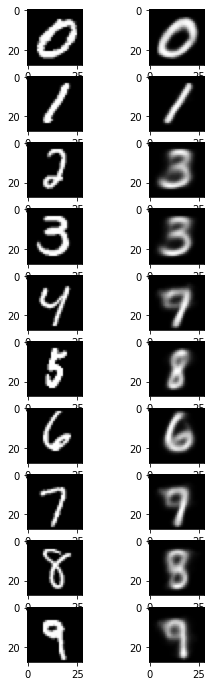

In [44]:
comp256_model = comp_models[0]
x_test_encoded_comp256 = comp256_model.predict(x_test, batch_size=batch_size)
print("model complexity: "+ str(model_complexities[0]))
plot_gallary(x_test_encoded=x_test_encoded_comp256)

model complexity: 1024


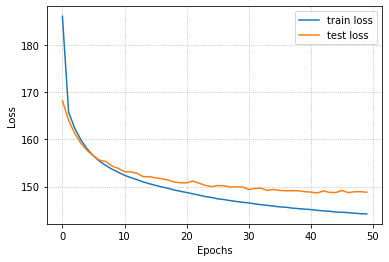

In [45]:
print("model complexity: "+ str(model_complexities[1]))
com1024_hist = tuningComp[1].history
lossPlot(com1024_hist['loss'],com1024_hist['val_loss'])

model complexity: 1024


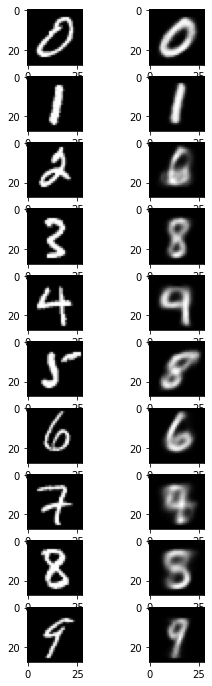

In [47]:
comp1024_model = comp_models[1]
x_test_encoded_comp1024 = comp1024_model.predict(x_test, batch_size=batch_size)
print("model complexity: "+ str(model_complexities[1]))
plot_gallary(x_test_encoded=x_test_encoded_comp1024)